In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from typing import Dict
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
start_date = '20180501'
end_date='20181231'
periods=[5,10,20,40,80,160,320]
breakout_periods=[20]
carver_periods=[20,40,60]
roc_periods = [5,10,20,40]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s, periods=periods),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=breakout_periods),
    'carver': calibrate_multiple(sym, carver, start_date=s, adjustment=40, periods=carver_periods),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=roc_periods),
    'roca': calibrate_multiple(sym, roca, start_date=s, periods=periods),
}

inds = {
    #'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    #'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=breakout_periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=carver_periods, adjustment=40),
    #'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=roc_periods),
    #'roca': simulate(params['roca'], sym, roca, start_date=start_date, end_date=end_date, periods=periods),
}

In [11]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
ema,8.55017,5.75621
carver,9.33856,5.57974


In [12]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,ema,carver
ema,1.000000,0.720399
carver,0.720399,1.000000


In [13]:
def binarize(series):
    df = pd.DataFrame()
    df['long'] = (series >= 5) * 1
    df['short'] = (series <= -5) * -1
    df['out'] = ((series > -5) & (series < 5)) * 0
    df['signal'] = df.sum(axis=1)
    return df['signal']

In [14]:
def combine(inds: Dict[str, pd.DataFrame]):
    df_in = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df_out = pd.DataFrame({name: binarize(df_in[name]) for name in df_in.columns})
    df_out['forecast'] = df_out.mean(axis=1).round()
    #df_out['forecast'] = df_out.mean(axis=1).apply(np.floor)
    df_out[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    return df_out

In [15]:
data=combine(inds)

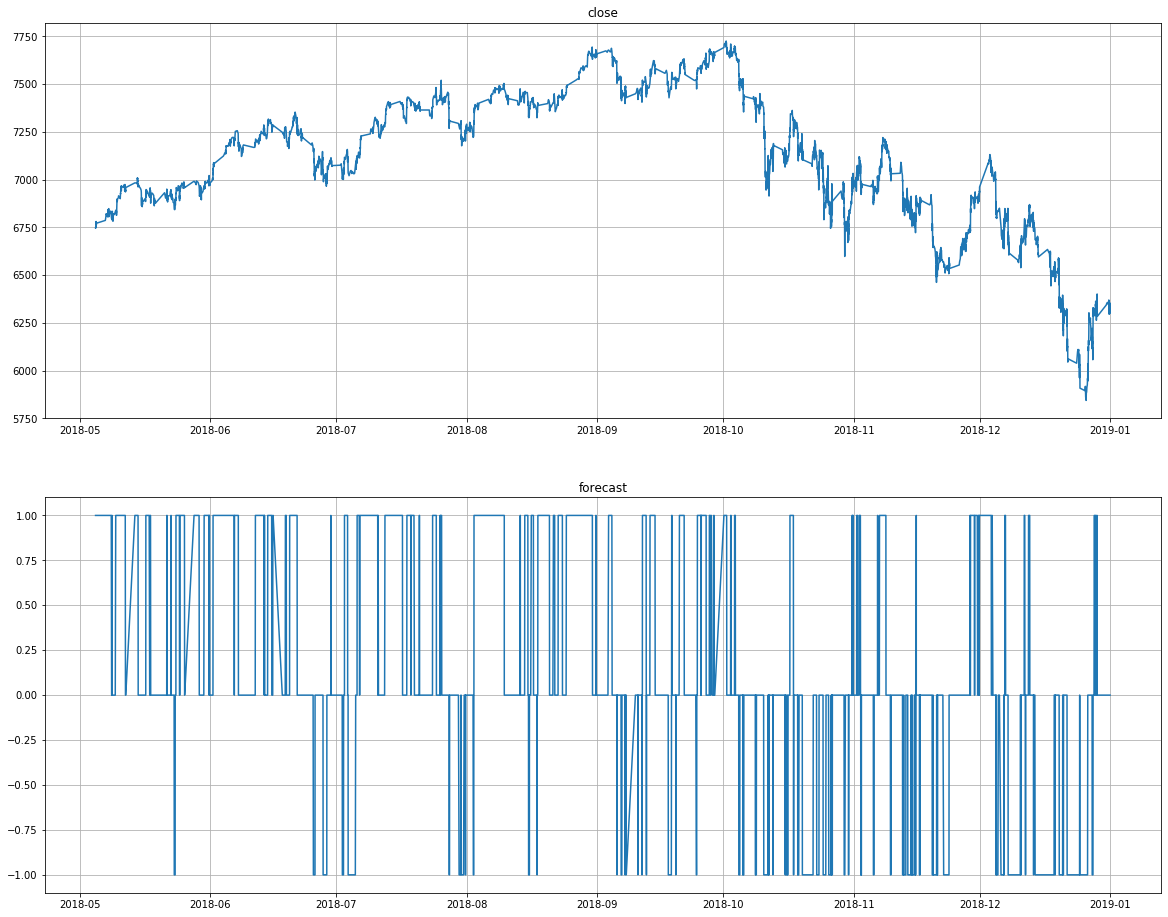

In [16]:
plot(data[['close', 'forecast']])

In [17]:
out = summary(data, slip=1.5)
out.stats

,0
Annual return,0.103827
Cumulative returns,0.0693289
Annual volatility,0.14246
Sharpe ratio,0.763854
Calmar ratio,1.81521
Stability,0.570644
Max drawdown,-0.0571983
Omega ratio,1.15212
Sortino ratio,1.32779
Skew,1.16825


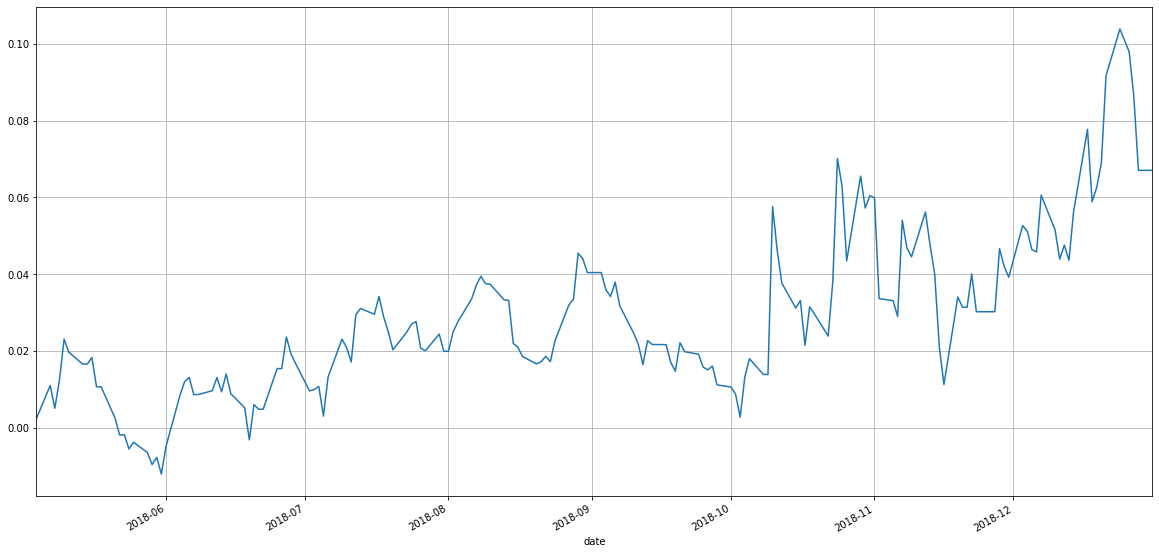

In [18]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [19]:
out.dfs[0].loc['20190501':'20190531'].pnl.sum()

0.0

In [20]:
out.dfs[0].pnl.resample('M').sum()

date
2018-05-31    -85.500
2018-06-30    206.000
2018-07-31     26.250
2018-08-31    156.000
2018-09-30   -217.750
2018-10-31    375.500
2018-11-30   -133.375
2018-12-31    203.125
Freq: M, Name: pnl, dtype: float64